# Basic feature engineering approaches on univariate / 1D time series data

In [1]:
# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ml training code
from src.one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_scaling

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

import random

# 0. Steam data: Number of users over time

<Axes: xlabel='Date', ylabel='Number of online users'>

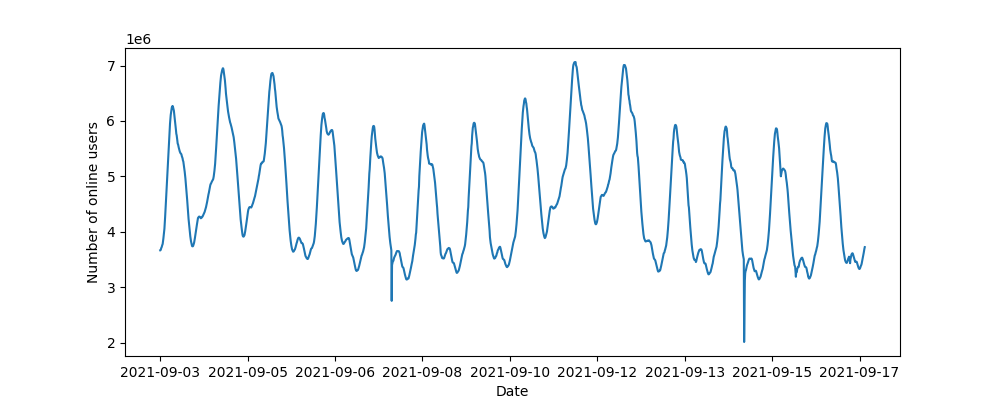

In [4]:
df = pd.read_csv('./test_data/chart_c.csv') 
df['Date'] = df['DateTime'].apply(lambda x: x[0:10])

fig, ax = plt.subplots(figsize=(10,4))
df.plot(x='Date',y='In-Game',xlabel='Date',ylabel='Number of online users',legend=False, ax=ax)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateTime     2016 non-null   object 
 1   Users        2016 non-null   int64  
 2   Users Trend  2016 non-null   float64
 3   In-Game      2016 non-null   int64  
 4   Date         2016 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 78.9+ KB


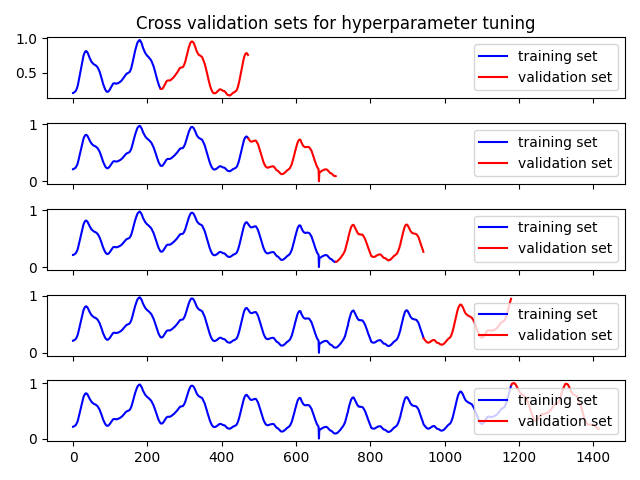


Naive model results:
MAPE: 0.04414598335746019
RMSE:  0.02018050614396417
MAE:  0.0105854428703944
Training multivariate linear regression:

Linear regression coefficients: 
 [-0.0937428  -0.02186503  0.0665263   0.06527221  0.04727499  0.02214794
 -0.02418    -0.01687878  0.01954381  0.03711714  0.00094326 -0.04531774
 -0.08682628 -0.11394653 -0.08355397 -0.07211419 -0.03603405  0.05442382
  0.33659087  0.93814454]
MAPE: 0.03416158629457352
RMSE:  0.01933096273583706
MAE:  0.005637796460468683

Training support vector machine:
best_score:  -0.05666203013037552
best_model:  SVR(C=100, kernel='linear', max_iter=5000, tol=1e-05)
best_params:  {'C': 100, 'kernel': 'linear'}
MAPE: 0.141568168987162
RMSE:  0.04807942806277329
MAE:  0.03542816806899132

Training MLP neural network: 
best_score:  -0.011323421306349094
best_model:  MLPRegressor(hidden_layer_sizes=(500,), max_iter=5000, n_iter_no_change=200,
             shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes':

FileNotFoundError: [Errno 2] No such file or directory: './results/univariate_single_step_ahead/min-max/steam_min-max.png'

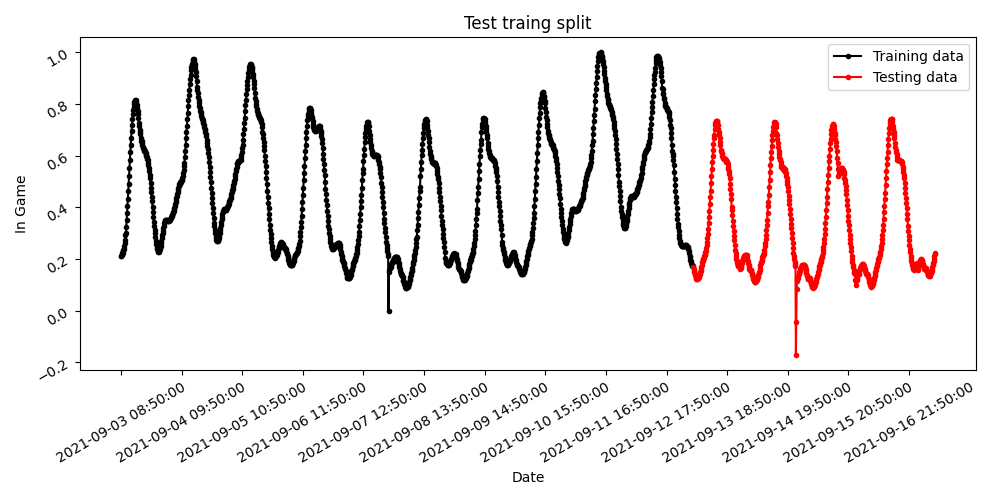

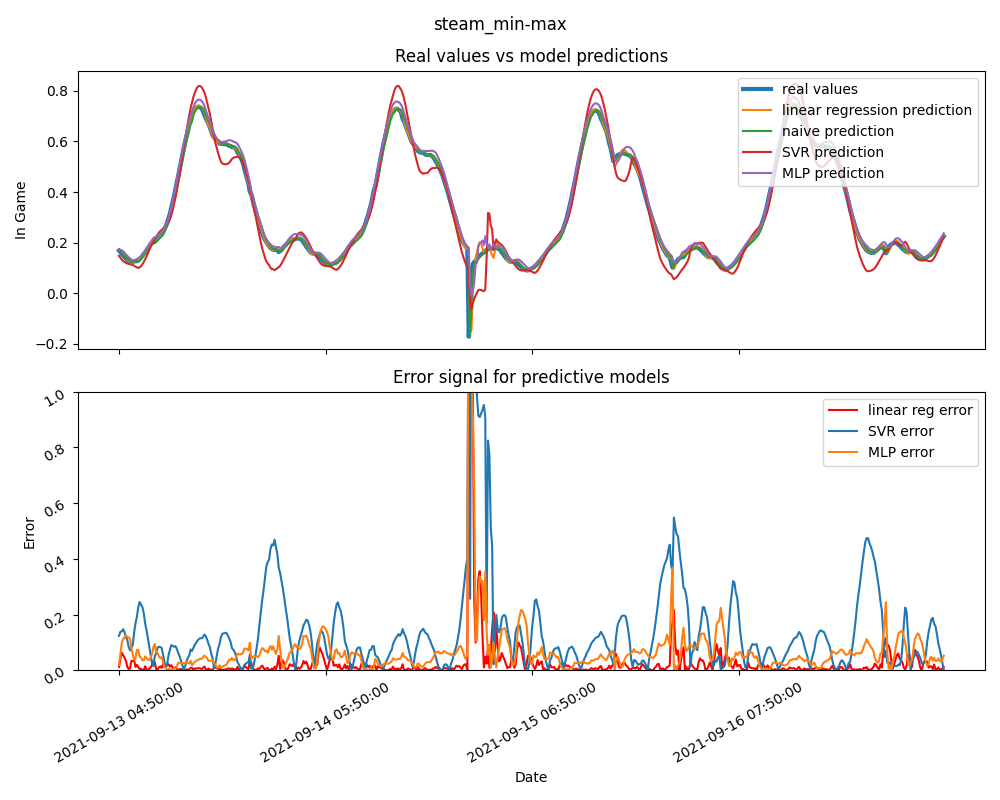

In [8]:
# model and forecast
window_length = 20
split = 600 

# scale and transform data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['In-Game'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['In-Game'][-split:].to_numpy().reshape(-1,1)).flatten()
data = np.append(scaled_training_data,scaled_test_data)

# model and forecast

# initialize class object
normal = time_series_prediction('steam','min-max',df['DateTime'],data,window_length,1)# pass: time series dates, univariate time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised ML problem
normal.train_test_split(split=split) # testing and training dataset split
normal.test_train_plot(steps=150,ylabel='In Game')    # visualize training split

# perform some prediction tasks
normal.naive_model()
normal.linear_regression()
normal.support_vector_machine(model_tunning=True)
normal.neural_net_mlp(model_tunning=True)

# visualize results
normal.vis_results_time_series(second_plot='error',ylabel='In Game')

# tabulate results
tabulated_results_0 = normal.results()
tabulated_results_0.plot(figsize=(10,4))
display(tabulated_results_0)


In [10]:
# what is the accuracy for these predictions

# data to feed to hit_rate function:
dates = tabulated_results_0['date'].iloc[split+window_length:]
original_values = tabulated_results_0['Value'].iloc[split+window_length:]
lin_predictions = tabulated_results_0['Linear'].iloc[split+window_length:]
svm_predictions = tabulated_results_0['SVM'].iloc[split+window_length:]
nn_predictions =  tabulated_results_0['NN'].iloc[split+window_length:]
naive_predictions =  tabulated_results_0['Naive'].iloc[split+window_length:]

# hit rate calculations
print('Linear Regression:')
df_lin = hit_rate(dates,original_values,lin_predictions)

print('SVM:')
df_svm = hit_rate(dates,original_values,svm_predictions)

print('NN:')
df_nn = hit_rate(dates,original_values,nn_predictions)

print('Naive:')
df_naive = hit_rate(dates,original_values,naive_predictions)


Linear Regression:
Movement prediction accuracy: 69.74 %
Confusion matrix:
[[596  28]
 [340 252]]
SVM:
Movement prediction accuracy: 69.41 %
Confusion matrix:
[[575  49]
 [323 269]]
NN:
Movement prediction accuracy: 68.17 %
Confusion matrix:
[[583  41]
 [346 246]]
Naive:
Movement prediction accuracy: 70.97 %
Confusion matrix:
[[598  26]
 [327 265]]


# 1.0 Forecast car sales data

In [12]:
# import some data
df = pd.read_csv('./test_data/monthly-car-sales.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df.plot(figsize=(10,4),legend=False,xlabel='Date',ylabel='Car sales',x='Month',y='Sales')
display(df)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587
...,...,...
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180


In [62]:
# model and forecast
window_length = 24
split = 12 

# scale input data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Sales'].to_numpy().reshape(-1,1)).flatten()

# initialize class object
normal = time_series_prediction('car sales', 'min-max', df['Month'],scaled_data,window_length,1)# pass: time series dates, univariate time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised ML problem
normal.train_test_split(split=split) # testing and training dataset split
normal.test_train_plot()    # visualize training split

# perform some prediction tasks
normal.naive_model()
normal.linear_regression()
normal.support_vector_machine(model_tunning=True)
normal.neural_net_mlp(model_tunning=True)

# visualize results
normal.vis_results_time_series(second_plot='error')

# tabulate results
tabulated_results_0 = normal.results()
tabulated_results_0.plot()
display(tabulated_results_0)

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587
...,...,...
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


Naive model results:
MAPE: 0.24500571523487513
RMSE:  0.18430501384630893
MAE:  0.1575990778172844
Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.29772767  0.0297656  -0.20719679  0.27396527 -0.23778335  0.16212262
 -0.20931553  0.49549408 -0.35280125  0.07677138  0.0266807  -0.25181929
  0.27417877  0.31350865 -0.06785588 -0.04478725 -0.05784719  0.06532542
 -0.18701502  0.03758605 -0.0996454   0.05197084 -0.10323055  0.46866853]
MAPE: 0.1196107089370718
RMSE:  0.09996775909519617
MAE:  0.07195515061502256

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.11147177783223991
best_model:  SVR(C=0.1, kernel='linear', max_iter=1000, tol=0.0001)
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.09419401581865157
RMSE:  0.09013089125697712
MAE:  0.06323249248997241

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.082902498

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

,date,Value,Linear,SVM,NN,Naive
0,1960-01,0.047830,None,None,None,None
1,1960-02,0.153914,None,None,None,None
2,1960-03,0.314549,None,None,None,None
3,1960-04,0.429935,None,None,None,None
4,1960-05,0.439287,None,None,None,None
...,...,...,...,...,...,...
103,1968-08,0.543276,0.652697,0.461913,0.460825,0.606692
104,1968-09,0.429448,0.364849,0.454352,0.461175,0.543276
105,1968-10,0.768302,0.623325,0.563868,0.582745,0.429448
106,1968-11,0.565584,0.604656,0.577314,0.613994,0.768302


In [51]:
# what is the accuracy of price movements for these predictions

# data to feed to hit_rate function:
dates = tabulated_results_0['date'].iloc[split+window_length:]
original_values = tabulated_results_0['Value'].iloc[split+window_length:]
lin_predictions = tabulated_results_0['Linear'].iloc[split+window_length:]
svm_predictions = tabulated_results_0['SVM'].iloc[split+window_length:]
nn_predictions =  tabulated_results_0['NN'].iloc[split+window_length:]
naive_predictions =  tabulated_results_0['Naive'].iloc[split+window_length:]

# hit rate calculations
print('Linear Regression:')
df_lin = hit_rate(dates,original_values,lin_predictions)

print('SVM:')
df_svm = hit_rate(dates,original_values,svm_predictions)

print('NN:')
df_nn = hit_rate(dates,original_values,nn_predictions)

print('Naive:')
df_naive = hit_rate(dates,original_values,naive_predictions)

Linear Regression:
Movement prediction accuracy: 59.72 %
Confusion matrix:
[[39  1]
 [28  4]]
SVM:
Movement prediction accuracy: 61.11 %
Confusion matrix:
[[39  1]
 [27  5]]
NN:
Movement prediction accuracy: 59.72 %
Confusion matrix:
[[38  2]
 [27  5]]
Naive:
Movement prediction accuracy: 56.94 %
Confusion matrix:
[[38  2]
 [29  3]]


# 2.0 Forecast AirPassenger dataset

In [2]:
# import some data
df = pd.read_csv('./test_data/AirPassengers.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df.plot(figsize=(10,4),legend=False,xlabel='Month',ylabel='Number of passengers',x='Month',y='#Passengers')
display(df)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [6]:
# set global forecasting variables:
window_length = 15
split = 44

# scale input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['#Passengers'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['#Passengers'][-split:].to_numpy().reshape(-1,1)).flatten()
data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
normal = time_series_prediction(df['Month'],data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised ML problem
normal.train_test_split(split=split) # testing and training dataset split
normal.test_train_plot(ylabel='Number of passengers',steps=10)    # visualize training split

# perform some prediction tasks
normal.linear_regression()
normal.support_vector_machine(model_tunning=True)
normal.neural_net_mlp(model_tunning=True)
normal.naive_model()

# visualize results
normal.vis_results_time_series(ylabel='Number of passengers' ,second_plot='error')

# tabulate results
tabulated_results_0 = normal.results()
tabulated_results_0.plot(figsize=(10,4),x='date')
display(tabulated_results_0)

# invert scaling and compute eval metric in orginal feature space
print('NN:')
inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,data[-split:],normal.neural_net_predictions)
print('SVM:')
inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,data[-split:],normal.svm_predictions)
print('Linear Regression:')
inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,data[-split:],normal.linear_reg_predictions)
print('Naive:')
inverted_predictions_naive, inverted_testing_data = invert_scaling(scaler,data[-split:],normal.svm_predictions)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.16953321 -0.42873263 -0.46798819  0.8561609   0.21445967 -0.1535412
  0.16140096 -0.11391802  0.06285835 -0.11578229  0.1539329  -0.15758695
  0.00512348  0.19895227  0.6377276 ]
MAPE: 0.03481933371011008
RMSE:  0.04454694350706747
MAE:  0.03419377565624118

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.09755614119770059
best_model:  SVR(C=1, kernel='linear', max_iter=5000, tol=0.0001)
best_params:  {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}
MAPE: 0.09006820817016158
RMSE:  0.10520400987958853
MAE:  0.08429384249913306

Training neural network: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_score:  -0.05730364721086081
best_model:  MLPRegressor(learning_rate='adaptive', learning_rate_init=0.01, max_iter=5000,
             shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

,date,Value,Linear,SVM,NN,Naive
0,1949-01,0.025890,None,None,None,None
1,1949-02,0.045307,None,None,None,None
2,1949-03,0.090615,None,None,None,None
3,1949-04,0.080906,None,None,None,None
4,1949-05,0.055016,None,None,None,None
...,...,...,...,...,...,...
139,1960-08,1.624595,1.672894,1.637268,1.615524,1.676375
140,1960-09,1.307443,1.338425,1.498825,1.455827,1.624595
141,1960-10,1.155340,1.07054,1.283198,1.206976,1.307443
142,1960-11,0.925566,1.000955,1.124034,1.084506,1.15534


NN:
MAPE: 0.061463795290564296
RMSE:  29.821530138140965
MAE:  24.043622537616795
SVM:
MAPE: 0.06566300023021915
RMSE:  32.50803905279285
MAE:  26.04679733223213
Linear Regression:
MAPE: 0.025727422643957155
RMSE:  13.765005543683841
MAE:  10.565876677778522
Naive:
MAPE: 0.06566300023021915
RMSE:  32.50803905279285
MAE:  26.04679733223213


In [7]:
# what is the accuracy of price movements for these predictions

# data to feed to hit_rate function:
dates = tabulated_results_0['date'].iloc[split+window_length:]
original_values = tabulated_results_0['Value'].iloc[split+window_length:]
lin_predictions = tabulated_results_0['Linear'].iloc[split+window_length:]
svm_predictions = tabulated_results_0['SVM'].iloc[split+window_length:]
nn_predictions =  tabulated_results_0['NN'].iloc[split+window_length:]
naive_predictions =  tabulated_results_0['Naive'].iloc[split+window_length:]

# hit rate calculations
print('Linear Regression:')
df_lin = hit_rate(dates,original_values,lin_predictions)

print('SVM:')
df_svm = hit_rate(dates,original_values,svm_predictions)

print('NN:')
df_nn = hit_rate(dates,original_values,nn_predictions)

print('Naive:')
df_naive = hit_rate(dates,original_values,naive_predictions)

Linear Regression:
Movement prediction accuracy: 69.41 %
Confusion matrix:
[[36  2]
 [24 23]]
SVM:
Movement prediction accuracy: 60.0 %
Confusion matrix:
[[32  6]
 [28 19]]
NN:
Movement prediction accuracy: 62.35 %
Confusion matrix:
[[32  6]
 [26 21]]
Naive:
Movement prediction accuracy: 52.94 %
Confusion matrix:
[[29  9]
 [31 16]]


- even with the volume data which seems more stationary than open price data, the forecasts are still dominated by t-1

In [26]:
plt.figure(figsize=(10,4))
plt.plot([5,10,15,20,25],linear_results,'o-',label='linear regression')
plt.plot([5,10,15,20,25],nn_results,'o-',label='neural net results')
plt.plot([5,10,15,20,25],svm_results,'o-',label='svm results')
plt.xlabel('Window length')
plt.ylabel('Testing RMSE')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# 3.0 try predict S&P 500 univariate

,Date,Open,High,Low,Close,Volume
0,2010-06-28,1077.500000,1082.599976,1071.449951,1074.569946,3896410000
1,2010-06-29,1071.099976,1071.099976,1035.180054,1041.239990,6136700000
2,2010-06-30,1040.560059,1048.079956,1028.329956,1030.709961,5067080000
3,2010-07-01,1031.099976,1033.579956,1010.909973,1027.369995,6435770000
4,2010-07-02,1027.650024,1032.949951,1015.929993,1022.580017,3968500000
...,...,...,...,...,...,...
1995,2018-05-31,2720.979980,2722.500000,2700.679932,2705.270020,4235370000
1996,2018-06-01,2718.699951,2736.929932,2718.699951,2734.620117,3684130000
1997,2018-06-04,2741.669922,2749.159912,2740.540039,2746.870117,3376510000
1998,2018-06-05,2748.459961,2752.610107,2739.510010,2748.800049,3517790000


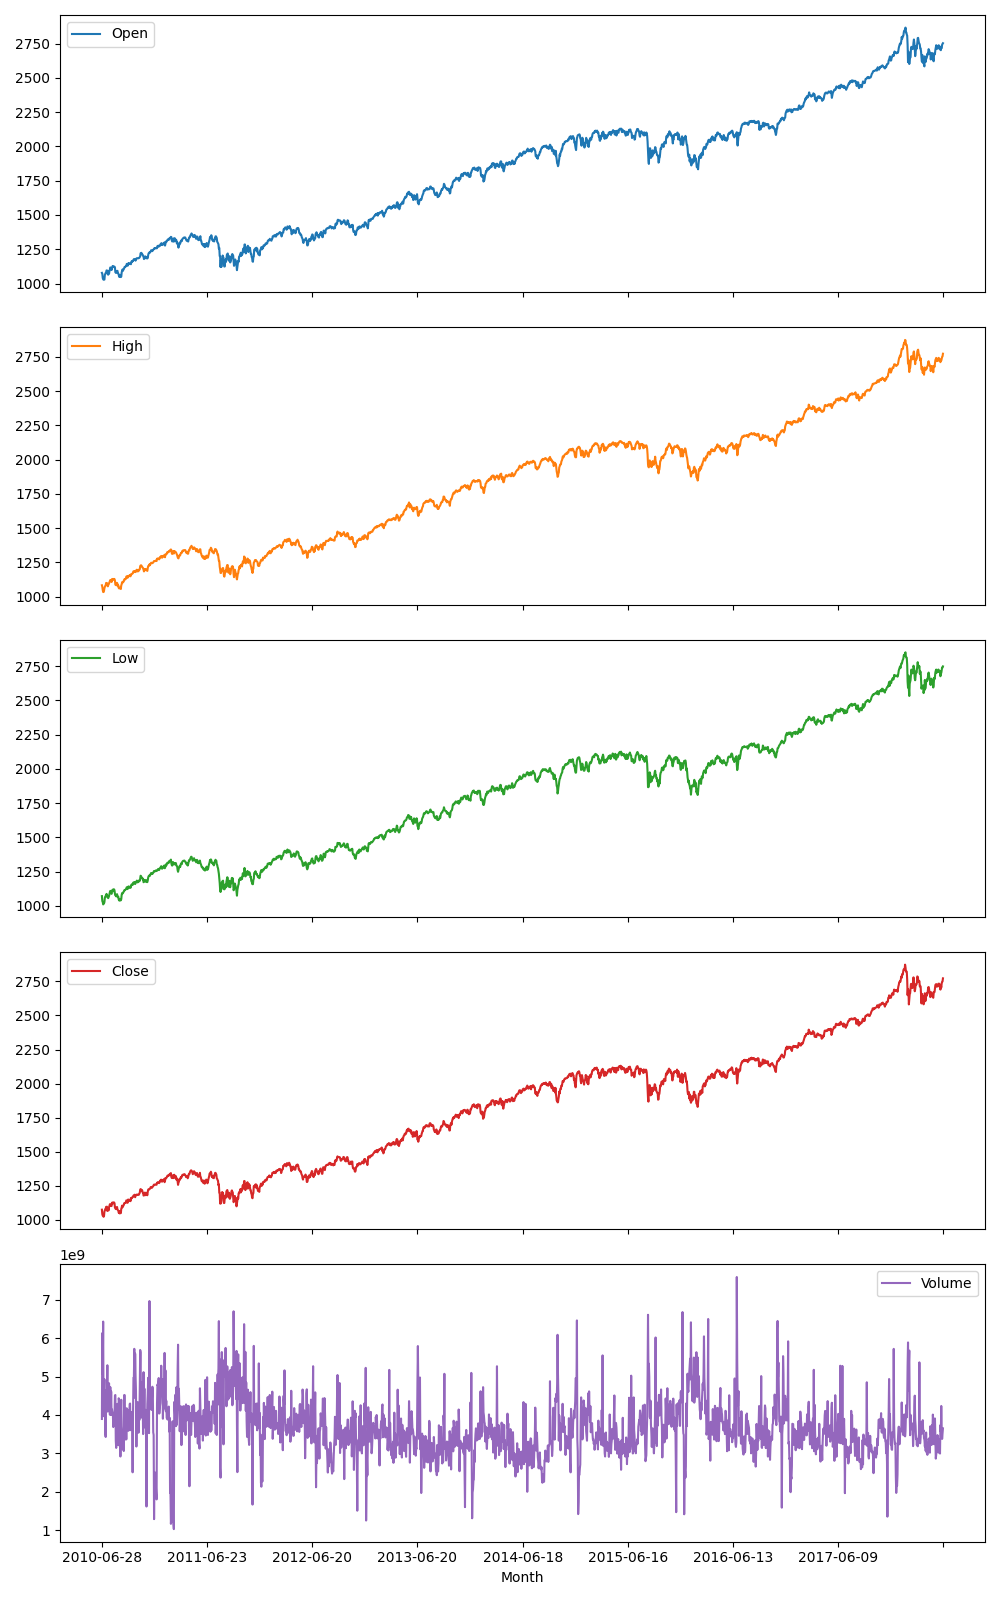

In [11]:
# import some data
df = pd.read_csv('./test_data/GSPC.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(figsize=(10,16),legend=True,xlabel='Month',subplots=True,x='Date')
plt.tight_layout()
display(df)

In [12]:
# set global forecasting variables:
ma_window = 5
window_length = 150
split = 500

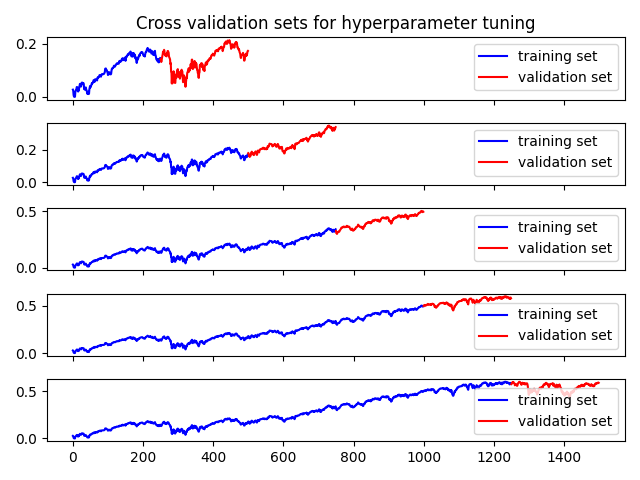

Training multivariate linear regression:

Linear regression coefficients: 
 [ 2.90171860e-02 -1.64140307e-02 -8.11602771e-03  4.23146896e-02
 -5.65588328e-02  6.00144615e-02 -5.93478971e-02  3.37578172e-02
 -7.62178394e-03 -3.56854188e-02  2.46652739e-02 -1.60071250e-02
  3.13970376e-02 -1.89157216e-02 -6.25345118e-03 -1.26310617e-02
  3.70751097e-02  2.41590213e-02 -3.64012621e-02 -1.89768801e-02
  8.20017341e-03 -2.02780196e-02 -1.08274605e-02  7.44137557e-02
 -2.39745458e-02 -4.62321440e-02  1.46137886e-02  6.89106769e-02
 -7.50413434e-02  8.90746325e-03  5.07346106e-02 -5.97468015e-02
 -5.49601673e-03 -3.55177065e-02  1.29471933e-01 -1.09444843e-01
  5.26299665e-03  5.27916773e-02 -2.11156756e-02  1.70715027e-02
 -4.83361085e-02  6.66796303e-02 -3.08388891e-02 -4.98988437e-02
  1.39034031e-02  4.62942512e-02 -3.76196920e-03 -7.25116898e-02
  5.40673503e-02  3.74713105e-02 -3.70771755e-02  2.56463085e-02
  5.07575320e-03 -4.38498519e-02  4.71603168e-03  2.06465671e-02
  2.98688068e-

,date,Value,Linear,SVM,NN,Naive
0,2010-06-28,0.027099,None,None,None,None
1,2010-06-29,0.023619,None,None,None,None
2,2010-06-30,0.007018,None,None,None,None
3,2010-07-01,0.001875,None,None,None,None
4,2010-07-02,0.000000,None,None,None,None
...,...,...,...,...,...,...
1995,2018-05-31,0.920498,0.910051,0.8196,0.961197,0.910414
1996,2018-06-01,0.919259,0.921096,0.820026,0.960659,0.920498
1997,2018-06-04,0.931745,0.92327,0.820439,0.960767,0.919259
1998,2018-06-05,0.935436,0.930143,0.821013,0.961128,0.931745


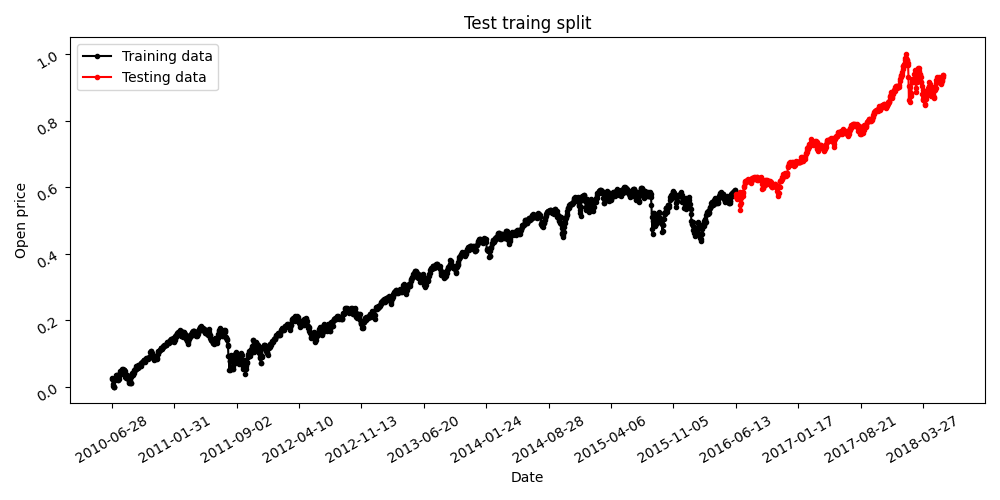

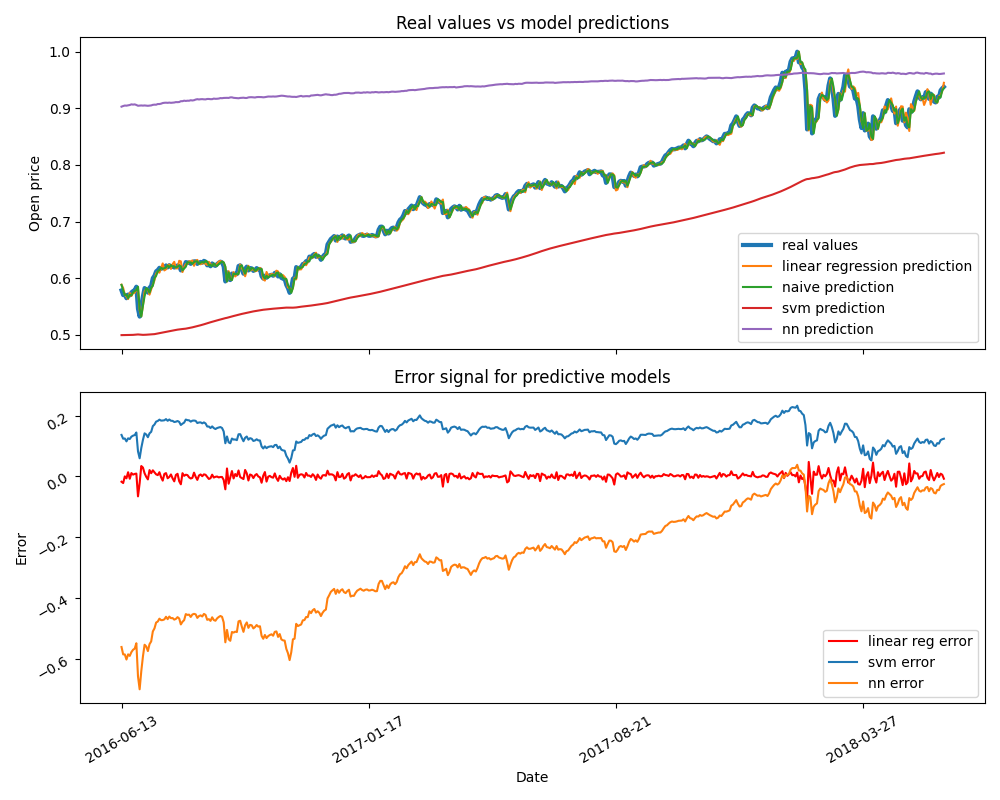

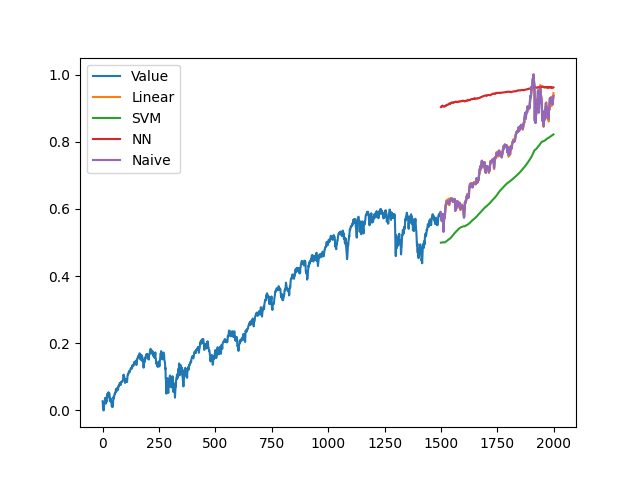

In [15]:
# scale input data
scaler = MinMaxScaler()
test_data_scaler = scaler.fit(df['Open'].iloc[0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_date = 

# initialize class object
normal = time_series_prediction(df['Date'],scaled_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised ML problem
normal.train_test_split(split=split) # testing and training dataset split
normal.test_train_plot(ylabel='Open price')    # visualize training split

# perform some prediction tasks
normal.linear_regression()
normal.support_vector_machine(model_tunning=True)
normal.neural_net_mlp(model_tunning=True)
normal.naive_model()

# visualize results
normal.vis_results_time_series(ylabel='Open price',second_plot='error')

# tabulate results
tabulated_results_0 = normal.results()
tabulated_results_0.plot()
display(tabulated_results_0)

In [16]:
# what is the accuracy of price movements for these predictions

# data to feed to hit_rate function:
dates = tabulated_results_0['date'].iloc[split+window_length:]
original_values = tabulated_results_0['Value'].iloc[split+window_length:]
lin_predictions = tabulated_results_0['Linear'].iloc[split+window_length:]
svm_predictions = tabulated_results_0['SVM'].iloc[split+window_length:]
nn_predictions =  tabulated_results_0['NN'].iloc[split+window_length:]
naive_predictions =  tabulated_results_0['Naive'].iloc[split+window_length:]

# hit rate calculations
print('Linear Regression:')
df_lin = hit_rate(dates,original_values,lin_predictions)

print('SVM:')
df_svm = hit_rate(dates,original_values,svm_predictions)

print('NN:')
df_nn = hit_rate(dates,original_values,nn_predictions)

print('Naive:')
df_naive = hit_rate(dates,original_values,naive_predictions)

Linear Regression:
Movement prediction accuracy: 48.67 %
Confusion matrix:
[[481 103]
 [590 176]]
SVM:
Movement prediction accuracy: 51.11 %
Confusion matrix:
[[391 193]
 [467 299]]
NN:
Movement prediction accuracy: 49.78 %
Confusion matrix:
[[474 110]
 [568 198]]
Naive:
Movement prediction accuracy: 48.52 %
Confusion matrix:
[[468 116]
 [579 187]]


# 4.0 Play around with standardization and prediction returns

In [9]:
# some misc data
x = df['#Passengers']#[-2000:]
dates = df['Month']#[-2000:]
# percentage returns
x_pct = x.pct_change().fillna(0)
x_pct

# create new df hold both
df = pd.DataFrame(columns=['Month','#Passengers','pct_change','pct_change_cumprod'])#pd.DataFrame(columns=['Dates','Open','pct_change','pct_change_cumprod']) # ,'log_transform'
df['Month'] = dates
df['#Passengers'] =  x
df['pct_change'] = x_pct
df['pct_change_cumprod'] = (x_pct + 1).cumprod()
# df['log_transform'] = np.log(df['Open'] )

df.reset_index(inplace=True,drop=True)

# plot
df.plot(subplots=True,sharex=True,figsize=(7,7))
plt.tight_layout()

# view data
df

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

,Month,#Passengers,pct_change,pct_change_cumprod
0,1949-01,112,0.000000,1.000000
1,1949-02,118,0.053571,1.053571
2,1949-03,132,0.118644,1.178571
3,1949-04,129,-0.022727,1.151786
4,1949-05,121,-0.062016,1.080357
...,...,...,...,...
139,1960-08,606,-0.025723,5.410714
140,1960-09,508,-0.161716,4.535714
141,1960-10,461,-0.092520,4.116071
142,1960-11,390,-0.154013,3.482143


- unsure what the log transform is required for

## 4.1 predicting using returns data

In [10]:
scaler = MinMaxScaler()
df['pct_change_normalised'] = df['pct_change'].to_numpy().reshape(-1, 1)

normal = time_series_prediction(df['Month'],df['pct_change_normalised'],15,1) # pass time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised learning ML problem
normal.train_test_split(split=120) # testing and training dataset split
normal.test_train_plot() 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# perform some prediction tasks
normal.linear_regression()
normal.support_vector_machine(model_tunning=True)
normal.neural_net_mlp(model_tunning=True)
normal.naive_model()

Training multivariate linear regression:

Linear regression coefficients: 
 [-0.00159895 -0.35412292  0.00448339 -0.21164916  0.1285251 ]
RMSE:  0.22897053338920142
MAE:  0.19776139115216448

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  -0.021892121675885994
best_model:  SVR(C=1)
best_params:  {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
RMSE:  0.16080037907558992
MAE:  0.11233707036293106

Training neural network: 
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done 140 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-3)]: Done 240 out of 240 | elapsed:    0.0s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done 140 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-3)]: Done 405 out of 405 | elapsed:    1.5s finished


best_score:  -0.03465973423531474
best_model:  MLPRegressor(hidden_layer_sizes=(1000,), learning_rate='adaptive',
             max_iter=1000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
RMSE:  0.1696706875583989
MAE:  0.13302081520156087

Naive model results:
RMSE:  0.2802672842896312
MAE:  0.23383246334482782


In [20]:
normal.vis_results_time_series(second_plot='error')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

some remarks on predictions using returns of open price:
- prediction accuracy of models look terrible. Is it even worth comparing feature engineering approaches if predictions are this bad?
- evaluating models using cummulative gains seems reasonable

# 5.0 Denosing using fourier transform 

In [11]:
from scipy.fft import fft, ifft, fftfreq

In [13]:
# apply discrete fourier transform
df = pd.read_csv('./test_data/GSPC.csv')
signal = np.array(df['Open'][-2000:]) # data
fft_coefficients = fft(signal) # fourier transform
fft_coefficients

array([ 3.66942187e+06     -0.j        ,  3.21287554e+03+487830.95056478j,
        1.12223495e+05+238171.48892065j, ...,
       -4.56458329e+03-189241.03923405j,  1.12223495e+05-238171.48892065j,
        3.21287554e+03-487830.95056478j])

In [14]:
# plot orignal signal and inverse fourier transform, shows you can transform signal to frequency domain, then back to time domain
inverse_fft = ifft(fft_coefficients)
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(df['Date'][-2000:],inverse_fft,'-',label='Inverse fourier data')
ax.plot(range(0,len(inverse_fft)),signal,'.',label='Real data')
ax.set_xlabel('Days')
ax.set_xticks([df['Date'][-2000:].iloc[x] for x in range(0,len(df['Date'][-2000:]),120)])
ax.legend()
ax.tick_params(rotation=30,labelsize=15)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\tristan\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [15]:
# plot amplitude vs frequency 
n = len(signal)

# get frequencies and psd
freqs = fftfreq(signal.shape[0]) # x axis of amplitude vs frequency graphs
psd = np.abs(fft_coefficients)/n # psd is amplitude/N, psd or power spectrum density is the magnitude of the coefficients resulting from fourier transform

# plot psd
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(freqs[1:int(n/2)],psd[1:int(n/2)])
ax.set_ylabel('Power spectrum',fontsize=15)
ax.set_xlabel('Frequencies',fontsize=15)
ax.set_title('FFT')
ax.tick_params(labelsize=15)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

observations from coefficient magnitude vs frequency graph:
- most frequencies have low amplitude
- can denoise signal by setting coefficients with low amplitude to zero - ie a thresholding approach. Here the threshold might be something like 0.06
- fyi: frequency = 1 / #days therefore 

In [26]:
# Threshold coefficients to denoise signal
psd_indices = psd > 3# 0.06 # mask
fft_filtered = fft_coefficients*psd_indices

# low pass filtering
# freq_indices = freqs < 0.003 
# fft_filtered = fft_coefficients*freq_indices

# inverse transform filter coefficients
inverse_transform_filtered = ifft(fft_filtered)

# plot this
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'][-2000:],signal,'-',label='Real data')
ax.plot(df['Date'][-2000:],inverse_transform_filtered,'-',label='Inverse fourier filtered')
ax.legend()
ax.set_title('Threshold = 0.06')
ax.set_xlabel('Days',fontsize=15)
ax.set_xticks([df['Date'][-2000:].iloc[x] for x in range(0,len(df['Date'][-2000:]),120)])
ax.tick_params(rotation=30,labelsize=15)

plt.tight_layout()

<ipython-input-26-671f65149377>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize=(10,5))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\tristan\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [27]:
# put together artifical data, here the training set is denoised and the testing set is left unchanged
df_data = pd.DataFrame(columns=['Dates','artificial_data'])
df_data['Dates'] = df['Date'][-2000:]
df_data['artificial_data'] = np.concatenate((np.real(inverse_transform_filtered)[-2000:-500],df['Open'][-500:].to_numpy()),axis=None)

# plot this
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'][-2000:],df['Open'][-2000:],'-',label='Real data')
ax.plot(df_data['Dates'],df_data['artificial_data'],'-',label='Artificial testing and training data')
ax.legend()
ax.set_title('Threshold = 0.06')
ax.set_xlabel('Days',fontsize=15)
ax.set_xticks([df['Date'][-2000:].iloc[x] for x in range(0,len(df['Date'][-2000:]),120)])
ax.tick_params(rotation=30,labelsize=15)

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 5.1 now run predictions by training on filtered data

In [29]:
# initializing predicition class object for denoise
fft_denoised = time_series_prediction(df['Date'][-2000:],df_data['artificial_data'],5,1) # pass time series, lag window length, a number of steps ahead to predict
fft_denoised.sliding_window_1(verbose=0) # time series to supervised learning ML problem
fft_denoised.train_test_split(split=1500) # testing and training dataset split
fft_denoised.test_train_plot() 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
# perform some prediction tasks
fft_denoised.linear_regression()
fft_denoised.support_vector_machine(model_tunning=True,C= 100, epsilon= 0.1, kernel= 'linear') # these values come from first training model on normal data
fft_denoised.neural_net_mlp(model_tunning=True,activation= 'tanh', hidden_layer_sizes= (1000,), learning_rate= 'constant', learning_rate_init= 0.001) # these values come from first training model on normal data

Training multivariate linear regression:

Linear regression coefficients: 
 [-1.03457371  3.60524758 -3.86652966  0.10714721  2.18860435]
RMSE:  62.968505530904785
MAE:  38.441808870062054

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done  79 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-3)]: Done 213 out of 240 | elapsed:    9.6s remaining:    1.1s
[Parallel(n_jobs=-3)]: Done 240 out of 240 | elapsed:   35.1s finished


best_score:  -1.7461269326506816
best_model:  SVR(C=0.1, kernel='linear')
best_params:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
RMSE:  46.55096053951141
MAE:  28.156603107903628

Training neural network: 
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done 104 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-3)]: Done 232 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-3)]: Done 405 out of 405 | elapsed:  3.3min finished


best_score:  -81.70563319845397
best_model:  MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
RMSE:  18.602506675966758
MAE:  11.907933230115955


In [183]:
fft_denoised.vis_results_time_series(second_plot='error')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 5.2 Compare denoised results to normal 

In [186]:
# run predictions on volume data without denoising

# initializing predicition class object for denoise
normal = time_series_prediction(sp_500['Date'][-2000:],sp_500['Volume'][-2000:]/1e9,5,1) # pass time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised learning ML problem
normal.train_test_split(split=1500) # testing and training dataset split
normal.test_train_plot() 

# perform some prediction tasks
normal.linear_regression()
normal.support_vector_machine(model_tunning=False,C= 100, epsilon= 0.1, kernel= 'linear')
normal.neural_net_mlp(model_tunning=False,activation= 'relu', hidden_layer_sizes= (100,), learning_rate= 'adaptive', learning_rate_init= 0.01)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Training multivariate linear regression:

Linear regression coefficients: 
 [0.09282714 0.02080688 0.04822414 0.15111368 0.44476971]
RMSE:  0.5274919871056635
MAE:  0.3471744942971835

Training support vector machine:
Model params:  {'C': 100, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 1000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
RMSE:  0.6609905743797734
MAE:  0.44956223654614363

Training neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
RMSE:  0.5354893

In [187]:
# compare results for denoised and normal data: pulling data from predicito objects
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.y_test,'-',label='real vals')
ax.plot(fft_denoised.time_series_dates[fft_denoised.training_split+fft_denoised.lag_window_length:],fft_denoised.linear_reg_predictions,'-',label='linear reg - denoised')
ax.plot(fft_denoised.time_series_dates[fft_denoised.training_split+fft_denoised.lag_window_length:],fft_denoised.svm_predictions,'-',label='svm - denoised')
ax.plot(fft_denoised.time_series_dates[fft_denoised.training_split+fft_denoised.lag_window_length:],fft_denoised.neural_net_predictions,'-',label='nn - denoised')

ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.linear_reg_predictions,'--',label='linear reg ')
ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.svm_predictions,'--',label='svm ')
ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.neural_net_predictions,'--',label='nn ')

ax.set_xticks([normal.time_series_dates[x] for x in range(normal.training_split,len(normal.time_series_dates),28)])
ax.tick_params(rotation=30)
ax.legend()
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

How to compare results before and after denoising?
- rmse for predictions of denoised data cant be compared to remse of predictions using normal data because you are comparing against two different signals, one noisy and one denoised.

# 6.0 Wavelet denoising

Drawbacks of fourier transform / denoising:
- requires stationary data
- no localization of when different frequencies occured
- thresholding fourier trasnform coefficients requires setting a hyperparameter - the threshold 

Benefits of wavelets transform:
- data does not need to be stationary
- localization of when frequencies occur

Drawbacks of wavelets for denoising:
- more hyperparameters, threshold value as well as selecting wavelet type

## 6.1 Wavelet transform / decomposition of time series signal

Wavelet denoisng method:
- First perform a wavelet transform of the open data, denoise by thresholding coefficients, then computes returns of denoised signal. Compute returns and perform forecasting. Transform predictions to value and compare. 

maximum level is 8


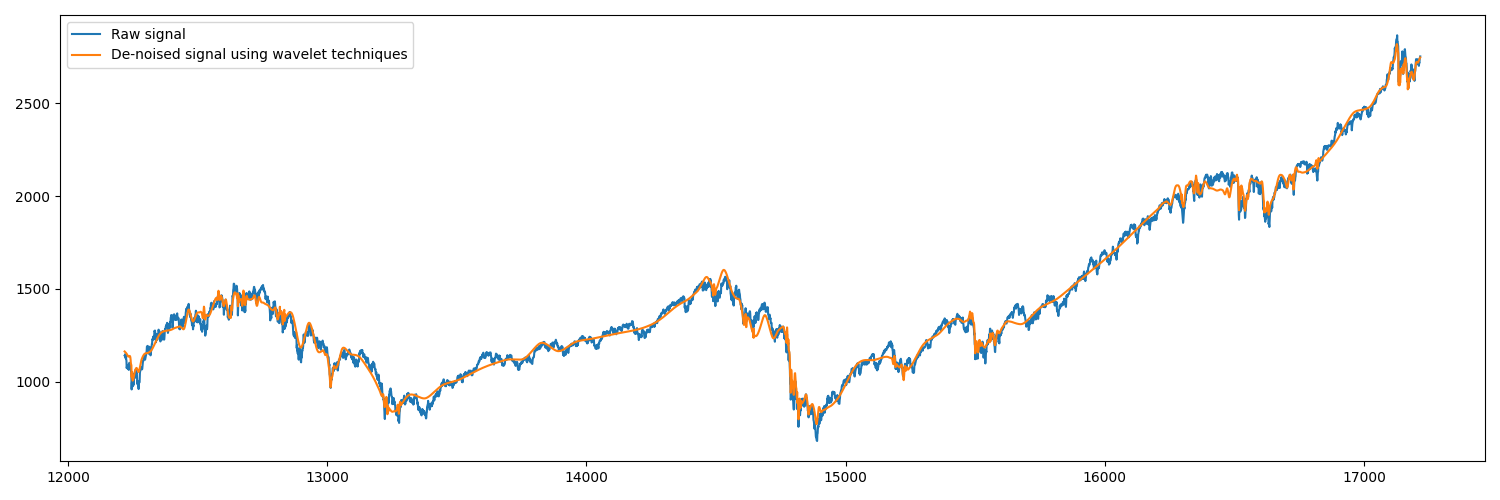

In [8]:
import pywt
import sys

# Data format:
# Raw data should be in a .txt file with two columns, separated by tabs:
#  - The first column should be a time-series index
#  - The second column should contain the data to be filtered

# Time series / data:
sp_500 = pd.read_csv('./test_data/GSPC.csv')
data = sp_500['Open'][-5000:] 

index = sp_500['Open'][-5000:].index

# Create wavelet object and define parameters
w = pywt.Wavelet('sym8') # sym family look good too sym8, this is where you should change the wavelet type, haar wavelet is simply 'haar'
maxlev = pywt.dwt_max_level(len(data), w.dec_len)
print("maximum level is " + str(maxlev))
threshold = 0.5 # Threshold for filtering coefficients as part of denoising, the higher this value the more coefficients you set to zero, ie more of the original signal you truncate away / denoise

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(data, w, level=maxlev)

# Threshold the wavelet coefficients, thereby removing noise

# plt.figure(figsize=(8,15))
for i in range(1, len(coeffs)):
    # plt.subplot(maxlev, 1, i)
    # plt.plot(coeffs[i],label='Original coefficients')
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]),mode='hard')
    # plt.plot(coeffs[i],label='Thresholded coefficients')
    # plt.ylabel('Scale: '+str(maxlev-i+1))
    # plt.legend()
    plt.tight_layout()

# inverse transform coefficient to reconstruct time series signal, minus noise
datarec = pywt.waverec(coeffs, w)

plt.figure(figsize=(15,5))
plt.plot(index, data,label='Raw signal')
plt.plot(index, datarec,label="De-noised signal using wavelet techniques")
plt.legend()
plt.tight_layout()
plt.show()

# Distance measures between true signal and denoised


In [32]:
coeffs = pywt.wavedec(data, w, level=maxlev)
coeffs_array = np.array(coeffs)
for i in range(len(coeffs)):
    print(i,' : ',len(coeffs[i]))

0  :  34
1  :  34
2  :  53
3  :  92
4  :  170
5  :  326
6  :  638
7  :  1261
8  :  2507


<ipython-input-32-b8260bc4145e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coeffs_array = np.array(coeffs)


## 6.2 Predictions: normal data vs wavelet denoised

predict sp500 open price one day ahead, using precentage returns

In [33]:
# some data processing: 

# create new df for normal data
df_normal = pd.DataFrame(columns=['Dates','Open','pct_change','pct_change_cumprod'])
df_normal['Dates'] = sp_500['Date'][-5000:]
df_normal['Open'] =   sp_500['Open'][-5000:]
df_normal['pct_change'] = df_normal['Open'].pct_change().fillna(0)
df_normal['pct_change_cumprod'] = (df_normal['pct_change']  + 1).cumprod()

df_normal.reset_index(inplace=True,drop=True)

# create new df for wavelet denoised data
df_denoised= pd.DataFrame(columns=['Dates','Open','pct_change','pct_change_cumprod'])
df_denoised['Dates'] = sp_500['Date'][-5000:]
df_denoised['Open'] =   datarec
df_denoised['pct_change'] = df_denoised['Open'].pct_change().fillna(0)
df_denoised['pct_change_cumprod'] = (df_denoised['pct_change']  + 1).cumprod()

df_denoised.reset_index(inplace=True,drop=True)

In [34]:
fig,ax = plt.subplots(figsize=(10,7))
df_normal.plot(subplots=True,ax=ax)
fig,ax = plt.subplots(figsize=(10,7))
df_denoised.plot(subplots=True,ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\tristan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\tristan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

## 6.2 Perform prediction on data

In [35]:
########################################################################
# forecasting on normal data
########################################################################

normal = time_series_prediction(df_denoised['Dates'],df_denoised['Open'],10,1) # pass time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised learning ML problem
normal.train_test_split(split=4500) # testing and training dataset split
normal.test_train_plot()    # visualize training split

# perform some prediction tasks
normal.linear_regression()
normal.support_vector_machine(model_tunning=True)
normal.neural_net_mlp(model_tunning=True)

#visualize results
normal.vis_results_time_series(second_plot='error')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Training multivariate linear regression:

Linear regression coefficients: 
 [ -0.37118873   1.60148038  -3.80273113   6.66461263  -9.43264085
  11.17871293 -11.26030921   9.50516526  -6.54416521   3.46098803]
RMSE:  51.06229108825765
MAE:  7.8499745596661095

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done  70 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-3)]: Done 193 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 240 out of 240 | elapsed:  2.3min finished


best_score:  -32.04620785441023
best_model:  SVR(C=1, epsilon=10, kernel='linear')
best_params:  {'C': 1, 'epsilon': 10, 'kernel': 'linear'}
RMSE:  28.757202725278542
MAE:  14.367173632655456

Training neural network: 
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done  98 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-3)]: Done 221 tasks      | elapsed:  2.1min


best_score:  -157.12155671576073
best_model:  MLPRegressor(hidden_layer_sizes=(10,), learning_rate='adaptive',
             learning_rate_init=0.01, max_iter=1000, shuffle=False)
best_params:  {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
RMSE:  37.696568049785725
MAE:  31.29134187499981


[Parallel(n_jobs=-3)]: Done 405 out of 405 | elapsed:  5.6min finished


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: x, y, and format string must not be None

In [8]:
########################################################################
# forecasting on denoised data
########################################################################

denoised = time_series_prediction(df_denoised['Dates'],df_denoised['pct_change'],10,1) # pass time series, lag window length, a number of steps ahead to predict
denoised.sliding_window_1(verbose=0) # time series to supervised learning ML problem
denoised.train_test_split(split=4500) # testing and training dataset split
denoised.test_train_plot() 

# perform some prediction tasks
denoised.linear_regression()
denoised.support_vector_machine(model_tunning=True,C= 0.1, epsilon= 10, kernel= 'linear')
denoised.neural_net_mlp(model_tunning=True,activation= 'relu', hidden_layer_sizes= (100,), learning_rate= 'adaptive', learning_rate_init= 0.001)

#visualize results
denoised.vis_results_time_series(second_plot='cumprod')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.0237145  -0.02246668  0.04740009  0.00701641  0.03584964 -0.03737366
 -0.03726144  0.05776496  0.03446961  0.17203609]
RMSE:  0.004456301705215824
MAE:  0.0016611758073728459

Training support vector machine:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done  70 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-3)]: Done 240 out of 240 | elapsed:    1.4s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
best_score:  -0.00023433945042440927
best_model:  SVR(C=0.1, epsilon=10, kernel='linear')
best_params:  {'C': 0.1, 'epsilon': 10, 'kernel': 'linear'}
RMSE:  0.015381430721325244
MAE:  0.014829075969529875

Training neural network: 
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-3)]: Done 140 tasks      | elapsed:    4.5s
[Paral

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 6.3 Compare results for normal vs denoised

In [114]:
# compare results for denoised and normal data
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.real_vals_cumprod,'-',label='real vals cumprod',linewidth=3)
ax.plot(denoised.time_series_dates[denoised.training_split+denoised.lag_window_length:],denoised.linear_reg_predictions_cumprod,'-',label='linear reg cumprod - denoised')
# ax.plot(denoised.time_series_dates[denoised.training_split+denoised.lag_window_length:],denoised.svm_predictions_cumprod,'-',label='svm cumprod - denoised')
ax.plot(denoised.time_series_dates[denoised.training_split+denoised.lag_window_length:],denoised.neural_net_predictions_cumprod,'-',label='nn cumprod - denoised')

ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.linear_reg_predictions_cumprod,'--',label='linear reg cumprod')
# ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.svm_predictions_cumprod,'--',label='svm cumprod')
ax.plot(normal.time_series_dates[normal.training_split+normal.lag_window_length:],normal.neural_net_predictions_cumprod,'--',label='nn cumprod')

ax.set_xticks([normal.time_series_dates[x] for x in range(normal.training_split,len(normal.time_series_dates),28)])
ax.tick_params(rotation=30)
ax.legend()
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 6.4 transform return predictions back to price data

When testing denoising methods, we need to compare against predictions without denoising. But once you denoise the original signal, you cant compare the RMSE metric of the denoised results to that of the normal (without denoising) prediction method because these metrics are computed against different based y_true values. So: 


- 1) transform price to returns
- 2) predict returns with and without denoising
- 3) convert returns to price and compute rmse, with and without denosing

In [115]:
# define some new dataframes to hold all data
df_normal_results = df_normal.iloc[4521:,:]
df_denoised_results = df_denoised.iloc[4521:,:]

# no denoising
df_normal_results['linear_reg_prices'] = df_normal['Open'][4521] * normal.linear_reg_predictions_cumprod
df_normal_results['svm_reg_prices'] = df_normal['Open'][4521] * normal.svm_predictions_cumprod
df_normal_results['nn_reg_prices'] = df_normal['Open'][4521] * normal.neural_net_predictions_cumprod

# with denoising
df_denoised_results['linear_reg_prices'] = df_denoised['Open'][4521] * denoised.linear_reg_predictions_cumprod
df_denoised_results['svm_reg_prices'] = df_denoised['Open'][4521] * denoised.svm_predictions_cumprod
df_denoised_results['nn_reg_prices'] = df_denoised['Open'][4521] * denoised.neural_net_predictions_cumprod

# plot results
plt.figure(figsize=(10,4))
plt.plot(df_normal_results['Dates'],df_normal_results['Open'],label='Real open data')

plt.plot(df_normal_results['Dates'],df_normal_results['linear_reg_prices'],label='linear normal')
# plt.plot(df_normal_results['Dates'],df_normal_results['svm_reg_prices'],label='svm normal')
plt.plot(df_normal_results['Dates'],df_normal_results['nn_reg_prices'],label='nn normal')

plt.plot(df_normal_results['Dates'],df_denoised_results['linear_reg_prices'],'--',label='linear denoised')
# plt.plot(df_normal_results['Dates'],df_denoised_results['svm_reg_prices'],label='svm denoised')
plt.plot(df_normal_results['Dates'],df_denoised_results['nn_reg_prices'],'--',label='nn denoised')


plt.xticks([df_normal_results['Dates'].iloc[x] for x in range(0,len(df_normal_results['Dates'][:]),28)])
plt.tick_params(rotation=30)
plt.legend()
plt.tight_layout()

<ipython-input-115-c730201f51f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal_results['linear_reg_prices'] = df_normal['Open'][4521] * normal.linear_reg_predictions_cumprod
<ipython-input-115-c730201f51f1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal_results['svm_reg_prices'] = df_normal['Open'][4521] * normal.svm_predictions_cumprod
<ipython-input-115-c730201f51f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [116]:
# compute evaluation metrics: look at RMSE between cummulative gains of real data vs predictions with and without denoising

# data
y_true = df_normal_results['Open']

# no denoising
y_pred_1 = df_normal_results['linear_reg_prices']
y_pred_2 = df_normal_results['svm_reg_prices']
y_pred_3 = df_normal_results['nn_reg_prices']

# with denoising
y_pred_4 = df_denoised_results['linear_reg_prices']
y_pred_5 = df_denoised_results['svm_reg_prices']
y_pred_6 = df_denoised_results['nn_reg_prices']

# metrics

rmse_linear_normal = mean_squared_error(y_true,y_pred_1)
rmse_svm_normal = mean_squared_error(y_true,y_pred_2)
rmse_ann_normal = mean_squared_error(y_true,y_pred_3)

rmse_linear_denoised = mean_squared_error(y_true,y_pred_4)
rmse_svn_denoised = mean_squared_error(y_true,y_pred_5)
rmse_ann_denoised = mean_squared_error(y_true,y_pred_6)

# print metrics
print('Linear normal - RMSE cumulatic gains:\t',rmse_linear_normal**0.5)
print('SVM normal - RMSE cumulatic gains:\t',rmse_svm_normal**0.5)
print('ANN normal - RMSE cumulatic gains:\t',rmse_ann_normal**0.5)

print('Linear denoised - RMSE cumulatic gains:\t',rmse_linear_denoised**0.5)
print('SVM denoised - RMSE cumulatic gains:\t',rmse_svn_denoised**0.5)
print('ANN denoised - RMSE cumulatic gains:\t',rmse_ann_denoised**0.5)



Linear normal - RMSE cumulatic gains:	 273.7957156081383
SVM normal - RMSE cumulatic gains:	 73853.8022660274
ANN normal - RMSE cumulatic gains:	 166.67343763907598
Linear denoised - RMSE cumulatic gains:	 178.58542289582076
SVM denoised - RMSE cumulatic gains:	 809173.9539076653
ANN denoised - RMSE cumulatic gains:	 306.7646744121744


Linear normal - RMSE cumulatic gains:	 103.78796952459727
SVM normal - RMSE cumulatic gains:	 2119.0777666368795
ANN normal - RMSE cumulatic gains:	 229.97477972358672
Linear denoised - RMSE cumulatic gains:	 49.60068080046763
SVM denoised - RMSE cumulatic gains:	 14452.351946378596
ANN denoised - RMSE cumulatic gains:	 115.447881267899

Summary of takeaways from denoising using signal processing techniques:
- Question, should you denoise before are after computing returns? 
    - Fourier transform needs to be computed on stationary signal(the sinusoids continue through infinity ie stationary), therefore you must do returns first?
    - Wavelet transform can be computed for non-stationary signals - see nice denosing of s&p 500 open prices

- How do we compare forecasting results for different denosing results?
    - RMSE or MAE against the denoised signals means we are comparing the forecasting results of fourier and wavelet denoised against different signals?
    - If we look at cumulative returns over testing dataset, then do we compare against the original cummulative returns?

- Some hyperparameters for wavelet transform:
    - type of wavelet, should be chosen based on data, all papers I've read have used the haar wavelet. Sym look better in my results.
    - Once the dwt transform is applied then a thresholding approach can be applied to set low coefficients to zero. Then iDWT taken to retrieve denoised signal. This threshold value and type of thresholding are another hyperparameter. 
    - The level of decomposition is also a hyperparameter. 

- Some hyperparameters for fourier transform:
    - thresholding value of different frequencies.

# some random extras

In [28]:
import pywt

# single level wavelet denoising
data = sp_500['Volume'][-2000:]/1e9
plt.figure(figsize=(15,5))
data.plot()

x = np.array(data)                
(ca, cd) = pywt.dwt(x, "sym20")                
cat = pywt.threshold(ca, 0.5, mode="hard")                
cdt = pywt.threshold(cd, 0.5, mode="soft")                
tx = pywt.idwt(cat, cdt, "sym20")

plt.plot(sp_500['Volume'][-2000:].index,tx,'-.')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',